In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

In [2]:
file_path = 'Data-Melbourne_F_fixed.csv'
dataset = pd.read_csv(file_path)

In [3]:
missing_values_summary = dataset.isnull().sum()
print("Missing Values Summary:")
print(missing_values_summary[missing_values_summary > 0])
dataset = dataset.fillna(dataset.mean())

Missing Values Summary:
Series([], dtype: int64)


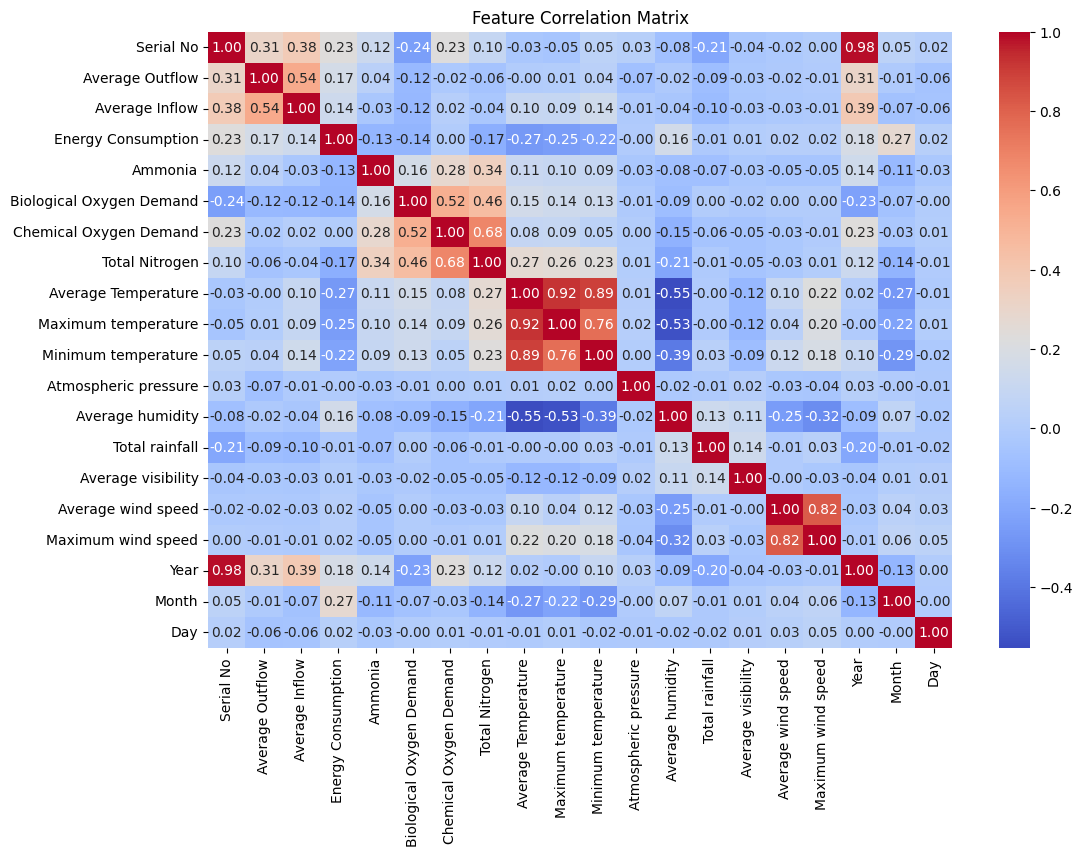

In [4]:
plt.figure(figsize=(12, 8))
sns.heatmap(dataset.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [5]:
dataset['Is_Outflow_Above_Average'] = (dataset['Average Outflow'] > dataset['Average Outflow'].mean()).astype(int)

feature_columns = dataset.drop(['Serial No', 'Average Outflow', 'Is_Outflow_Above_Average'], axis=1)
target_column = dataset['Is_Outflow_Above_Average']

X_train, X_test, y_train, y_test = train_test_split(
    feature_columns, target_column, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
def custom_sigmoid_function(input_value):
    return 1 / (1 + np.exp(-input_value))

def custom_logistic_regression(X, y, learning_rate=0.01, num_iterations=1000):
    num_samples, num_features = X.shape
    weights = np.zeros(num_features)
    bias = 0
    
    for iteration in range(num_iterations):
        linear_output = np.dot(X, weights) + bias
        predictions = custom_sigmoid_function(linear_output)
        
        gradient_weights = (1 / num_samples) * np.dot(X.T, (predictions - y))
        gradient_bias = (1 / num_samples) * np.sum(predictions - y)
        
        weights -= learning_rate * gradient_weights
        bias -= learning_rate * gradient_bias
        
    return weights, bias

# Train logistic regression model from scratch
model_weights, model_bias = custom_logistic_regression(
    X_train_scaled, y_train.values
)

# Predict using the custom logistic regression model
def custom_logistic_predict(X, weights, bias):
    linear_output = np.dot(X, weights) + bias
    predictions = custom_sigmoid_function(linear_output)
    return [1 if p > 0.5 else 0 for p in predictions]

predictions_logistic_scratch = custom_logistic_predict(
    X_test_scaled, model_weights, model_bias
)


In [7]:
# Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train_scaled, y_train)
predictions_logistic_sklearn = logistic_model.predict(X_test_scaled)

# K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
predictions_knn_sklearn = knn_model.predict(X_test_scaled)


In [ ]:
# KNN from scratch
def knn_from_scratch(X_train, y_train, X_test, k=5):
    distances = cdist(X_test, X_train, 'euclidean')
    neighbors = np.argsort(distances, axis=1)[:, :k]
    
    predictions = []
    for i in range(neighbors.shape[0]):
        nearest_labels = y_train.iloc[neighbors[i]].values
        predictions.append(np.bincount(nearest_labels).argmax())
    
    return np.array(predictions)

predictions_knn_scratch = knn_from_scratch(
    X_train_scaled, y_train, X_test_scaled, k=5
)

In [8]:
# Decision Tree Classifier
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)
predictions_decision_tree = decision_tree_model.predict(X_test)

# Random Forest Classifier with hyperparameter tuning
random_forest_params = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]}
random_forest_model = GridSearchCV(
    RandomForestClassifier(random_state=42), random_forest_params, cv=3, scoring='f1'
)
random_forest_model.fit(X_train, y_train)
predictions_random_forest = random_forest_model.best_estimator_.predict(X_test)


In [9]:
# Support Vector Machine (SVM) with hyperparameter tuning
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svm_model = GridSearchCV(SVC(), svm_params, cv=3, scoring='f1')
svm_model.fit(X_train_scaled, y_train)
print("Best SVM Parameters:", svm_model.best_params_)
predictions_svm_sklearn = svm_model.best_estimator_.predict(X_test_scaled)

Best SVM Parameters: {'C': 10, 'kernel': 'linear'}



Model: Logistic Regression (Scratch)
Accuracy: 0.7328519855595668
F1 Score: 0.6666666666666666
Confusion Matrix:
 [[129  36]
 [ 38  74]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.78      0.78       165
           1       0.67      0.66      0.67       112

    accuracy                           0.73       277
   macro avg       0.72      0.72      0.72       277
weighted avg       0.73      0.73      0.73       277



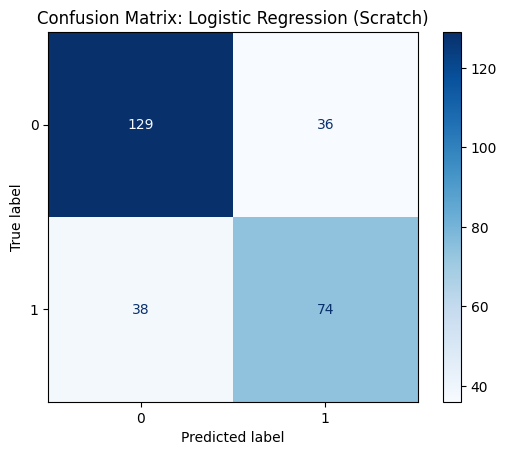


Model: Logistic Regression (sklearn)
Accuracy: 0.8050541516245487
F1 Score: 0.7522935779816514
Confusion Matrix:
 [[141  24]
 [ 30  82]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84       165
           1       0.77      0.73      0.75       112

    accuracy                           0.81       277
   macro avg       0.80      0.79      0.80       277
weighted avg       0.80      0.81      0.80       277



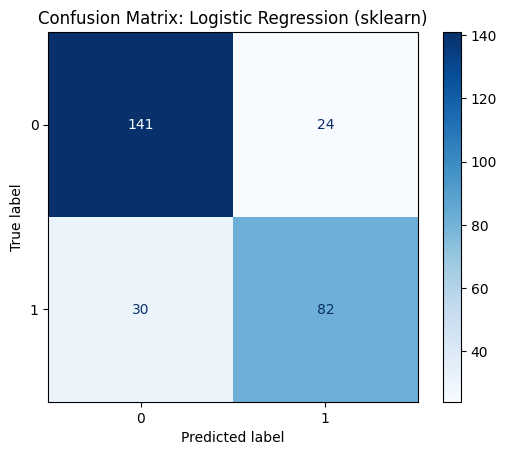


Model: K-Nearest Neighbors (sklearn)
Accuracy: 0.7509025270758123
F1 Score: 0.6986899563318777
Confusion Matrix:
 [[128  37]
 [ 32  80]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79       165
           1       0.68      0.71      0.70       112

    accuracy                           0.75       277
   macro avg       0.74      0.75      0.74       277
weighted avg       0.75      0.75      0.75       277



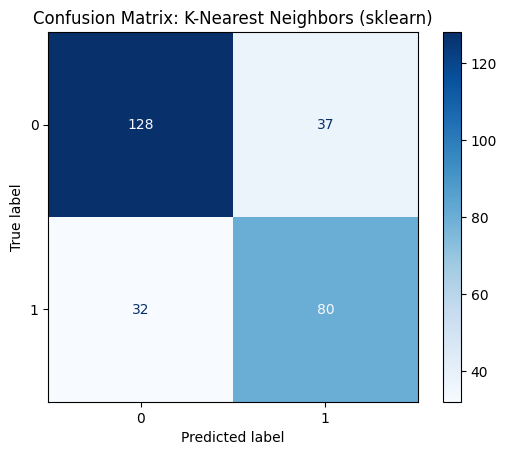


Model: Decision Tree
Accuracy: 0.7689530685920578
F1 Score: 0.7264957264957265
Confusion Matrix:
 [[128  37]
 [ 27  85]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.80       165
           1       0.70      0.76      0.73       112

    accuracy                           0.77       277
   macro avg       0.76      0.77      0.76       277
weighted avg       0.77      0.77      0.77       277



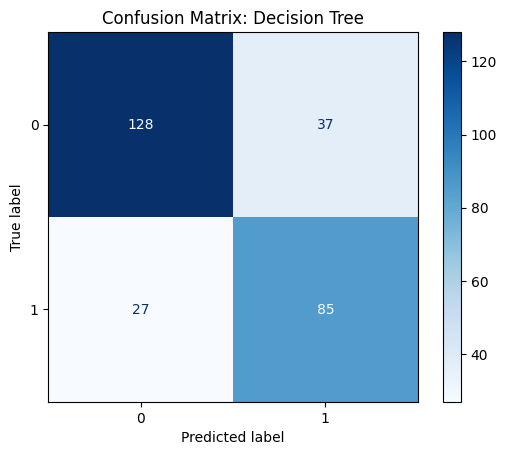


Model: Random Forest
Accuracy: 0.8158844765342961
F1 Score: 0.7918367346938775
Confusion Matrix:
 [[129  36]
 [ 15  97]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.78      0.83       165
           1       0.73      0.87      0.79       112

    accuracy                           0.82       277
   macro avg       0.81      0.82      0.81       277
weighted avg       0.83      0.82      0.82       277



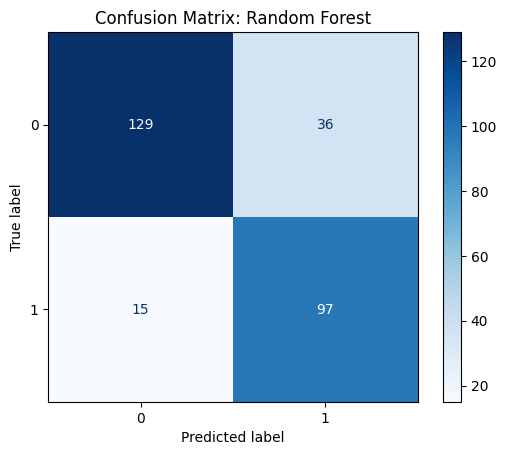


Model: Support Vector Machine (sklearn)
Accuracy: 0.8194945848375451
F1 Score: 0.782608695652174
Confusion Matrix:
 [[137  28]
 [ 22  90]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.85       165
           1       0.76      0.80      0.78       112

    accuracy                           0.82       277
   macro avg       0.81      0.82      0.81       277
weighted avg       0.82      0.82      0.82       277



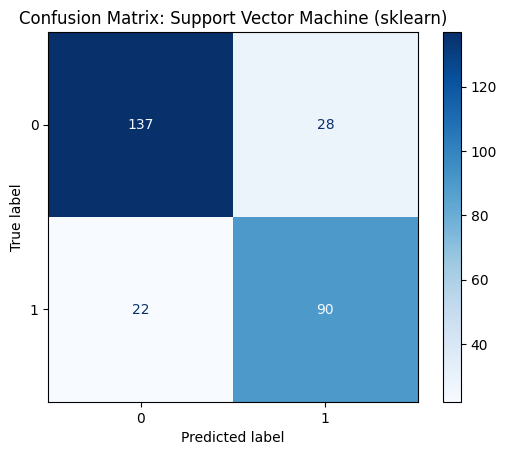


Model: K-Nearest Neighbors (Scratch)
Accuracy: 0.7509025270758123
F1 Score: 0.6986899563318777
Confusion Matrix:
 [[128  37]
 [ 32  80]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79       165
           1       0.68      0.71      0.70       112

    accuracy                           0.75       277
   macro avg       0.74      0.75      0.74       277
weighted avg       0.75      0.75      0.75       277



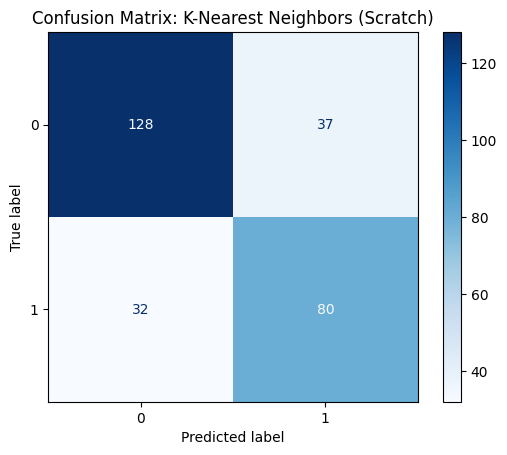

In [12]:
def evaluate_model(test_targets, predicted_targets, model_name):
    print(f"\nModel: {model_name}")
    print("Accuracy:", accuracy_score(test_targets, predicted_targets))
    print("F1 Score:", f1_score(test_targets, predicted_targets))
    print("Confusion Matrix:\n", confusion_matrix(test_targets, predicted_targets))
    print("Classification Report:\n", classification_report(test_targets, predicted_targets))

    # Plot confusion matrix
    confusion_mat = confusion_matrix(test_targets, predicted_targets)
    display = ConfusionMatrixDisplay(confusion_matrix=confusion_mat)
    display.plot(cmap="Blues")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

# Evaluate predictions from different models
evaluate_model(y_test, predictions_logistic_scratch, "Logistic Regression (Scratch)")
evaluate_model(y_test, predictions_logistic_sklearn, "Logistic Regression (sklearn)")
evaluate_model(y_test, predictions_knn_sklearn, "K-Nearest Neighbors (sklearn)")
evaluate_model(y_test, predictions_decision_tree, "Decision Tree")
evaluate_model(y_test, predictions_random_forest, "Random Forest")
evaluate_model(y_test, predictions_svm_sklearn, "Support Vector Machine (sklearn)")
evaluate_model(y_test, predictions_knn_scratch, "K-Nearest Neighbors (Scratch)")
